### Imports

In [1]:
### Standard imports
import os
import random
import numpy as np
import pandas as pd
import nibabel as nib
import tensorflow as tf

from glob import glob
from os.path import join
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Grey masks

In [2]:
masks = glob("/Volumes/hd_4tb/masks/plip/*")
masks = [{
    "code": os.path.basename(mask).split("_")[0],
    "data": nib.load(mask).get_data(),
} for mask in masks]

def _in_mask(masks, x, y, z):
    result = dict()
    for mask in masks:
        code = mask["code"]
        data = mask["data"]
        result["in_%s" % code] = int(bool(data[x, y, z]))
    return result

def _mean_activation(masks, fmri, grey, t, label):
    activations = dict()
    for mask in masks:
        code, data = mask["code"], mask["data"]
        region = np.multiply(data, fmri[:, :, :, t])
        activations["mean_%s_%s" % (code, label)] = np.mean( np.multiply(grey, region) )
    return activations

def _mask_info(masks, fmri, grey, coord):
    x, y, z, t = coord
    info = _in_mask(masks, x, y, z)
    for timepoint, label in [(t-1, "prev"), (t+1, "next")]:
        info = {**info, **_mean_activation(masks, fmri, grey, timepoint, label)}
    info["x"] = x
    info["y"] = y
    info["z"] = z
    info["t"] = t
    return info

print(_in_mask(masks, 49, 66, 33))

{'in_001716': 1, 'in_013136': 0, 'in_073720': 0, 'in_125909': 0, 'in_131520': 0, 'in_156999': 0, 'in_176064': 0, 'in_182355': 0, 'in_216192': 0, 'in_275836': 0, 'in_291082': 0, 'in_414207': 0, 'in_426426': 0, 'in_447647': 0, 'in_450767': 0, 'in_477522': 0, 'in_525931': 0, 'in_532911': 0, 'in_533294': 0, 'in_534482': 0, 'in_707656': 0, 'in_752691': 0, 'in_779062': 0, 'in_791103': 0, 'in_831650': 0, 'in_877949': 0, 'in_911981': 0, 'in_954861': 0}


### fMRI

In [3]:
def _load_volume(fmri, x, y, z, t):
    volume = nii_input(fmri[:, :, :, t], x, y, z)
    return np.array(volume)

def _load(filepath):
    return nib.as_closest_canonical(nib.load(filepath))

def _get_data(filepath):
    image = _load(filepath)
    return image.get_data()

def _time_map(session):
    _map = {
        "s1": "000", "s2": "2MO", "s3": "6MO", "s4": "12MO", "s5": "24MO"
    }
    return _map[session]

def _get(row, item):
    return row[item]

def _fmri_path(row):
    _input = "/Volumes/hd_4tb/raw"
    project = _get(row, "project")
    subject = _get(row, "subject")
    time_session = _get(row, "time_session")
    task = _get(row, "task")
    return join(_input, project, _time_map(time_session), subject, task)

def nii_input(data, x, y, z, r = 4):
    return data[
        x - r : x + r + 1,
        y - r : y + r + 1,
        z - r : z + r + 1
    ]

### Onsets

In [4]:
def _onset_time(onsets, curr_time):
    onset = onsets[onsets["ons"] < curr_time]
    onset = onset.sort_values("ons", ascending=False)
    if len(onset) > 0:
        _time = onset.iloc[0].ons
        return curr_time - _time
    return False

def _stim_time(df, stimuli, curr_time):
    stim = df[df.category == stimuli]
    return _onset_time(stim, curr_time)

def _keypress_times(df, button, curr_time):
    keys = df[(
        (df["category"] == "keypress") &
        (df["stimulus"] == button)
    )]
    return _onset_time(keys, curr_time)

def last_onset(onset_df, task, curr_time, max_time=1000):
    task_stimuli = {
        "gonogo":       ["Go", "NoGo"],
        "conscious":    ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sad"],
        "nonconscious": ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sad"],
        "workingmemSB": ["Baseline", "NonTarget", "Target"],
        "workingmemMB": ["Baseline", "NonTarget", "Target"],
    }
    all_stimuli  = set(np.concatenate(list(task_stimuli.values())))
    onset_timing = {stimuli: max_time for stimuli in all_stimuli}
    for button in ["1", "6"]:
        onset_timing[button] = _keypress_times(onset_df, button, curr_time)
        
    for stimuli in task_stimuli[task]:
        _time = _stim_time(onset_df, stimuli, curr_time)
        if _time:
            onset_timing[stimuli] = _time
    return pd.DataFrame(onset_timing, index=[1])

### Model

Add mean mask activation

In [5]:
def _checkpoint():
    return False

def _load_model():
    info_input = keras.Input(shape=(130,), name="info")
    prev_input = keras.Input(shape=(9, 9, 9, 2), name="prev")
    next_input = keras.Input(shape=(9, 9, 9, 2), name="next")

    prev_conv1 = layers.Conv3D(2, (3, 3, 3))(prev_input)
    next_conv1 = layers.Conv3D(2, (3, 3, 3))(next_input)
    prev_conv2 = layers.Conv3D(2, (2, 2, 2))(prev_conv1)
    next_conv2 = layers.Conv3D(2, (2, 2, 2))(next_conv1)
    
    info_1    = layers.Dense(130)(info_input)
    info_2    = layers.Dense(130)(info_1)
    flat_prev = layers.Flatten()(prev_conv2)
    flat_next = layers.Flatten()(next_conv2)

    x_0 = layers.concatenate([flat_prev, flat_next, info_2])
    x_1 = layers.Dense(994)(x_0)
    x_2 = layers.Dense(994)(x_1)
    x_3 = layers.Dense(800)(x_2)
    x_4 = layers.Dense(512)(x_3)
    x_5 = layers.Dense(256)(x_4)
    x_6 = layers.Dense(256)(x_5)
    x_7 = layers.Dense(128)(x_6)
    x_8 = layers.Dense( 64)(x_7)
    x_8 = layers.Dense( 32)(x_7)
    bold_signal = layers.Dense(1, activation="sigmoid", name="bold_signal")(x_8)

    model = keras.Model(inputs=[prev_input, next_input, info_input], outputs=[bold_signal])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
          loss={"bold_signal": "mean_squared_error"},
          loss_weights=[1.])
#     if _checkpoint():
#         model.load_weights("checkpoint_path")
    return model

### Load model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


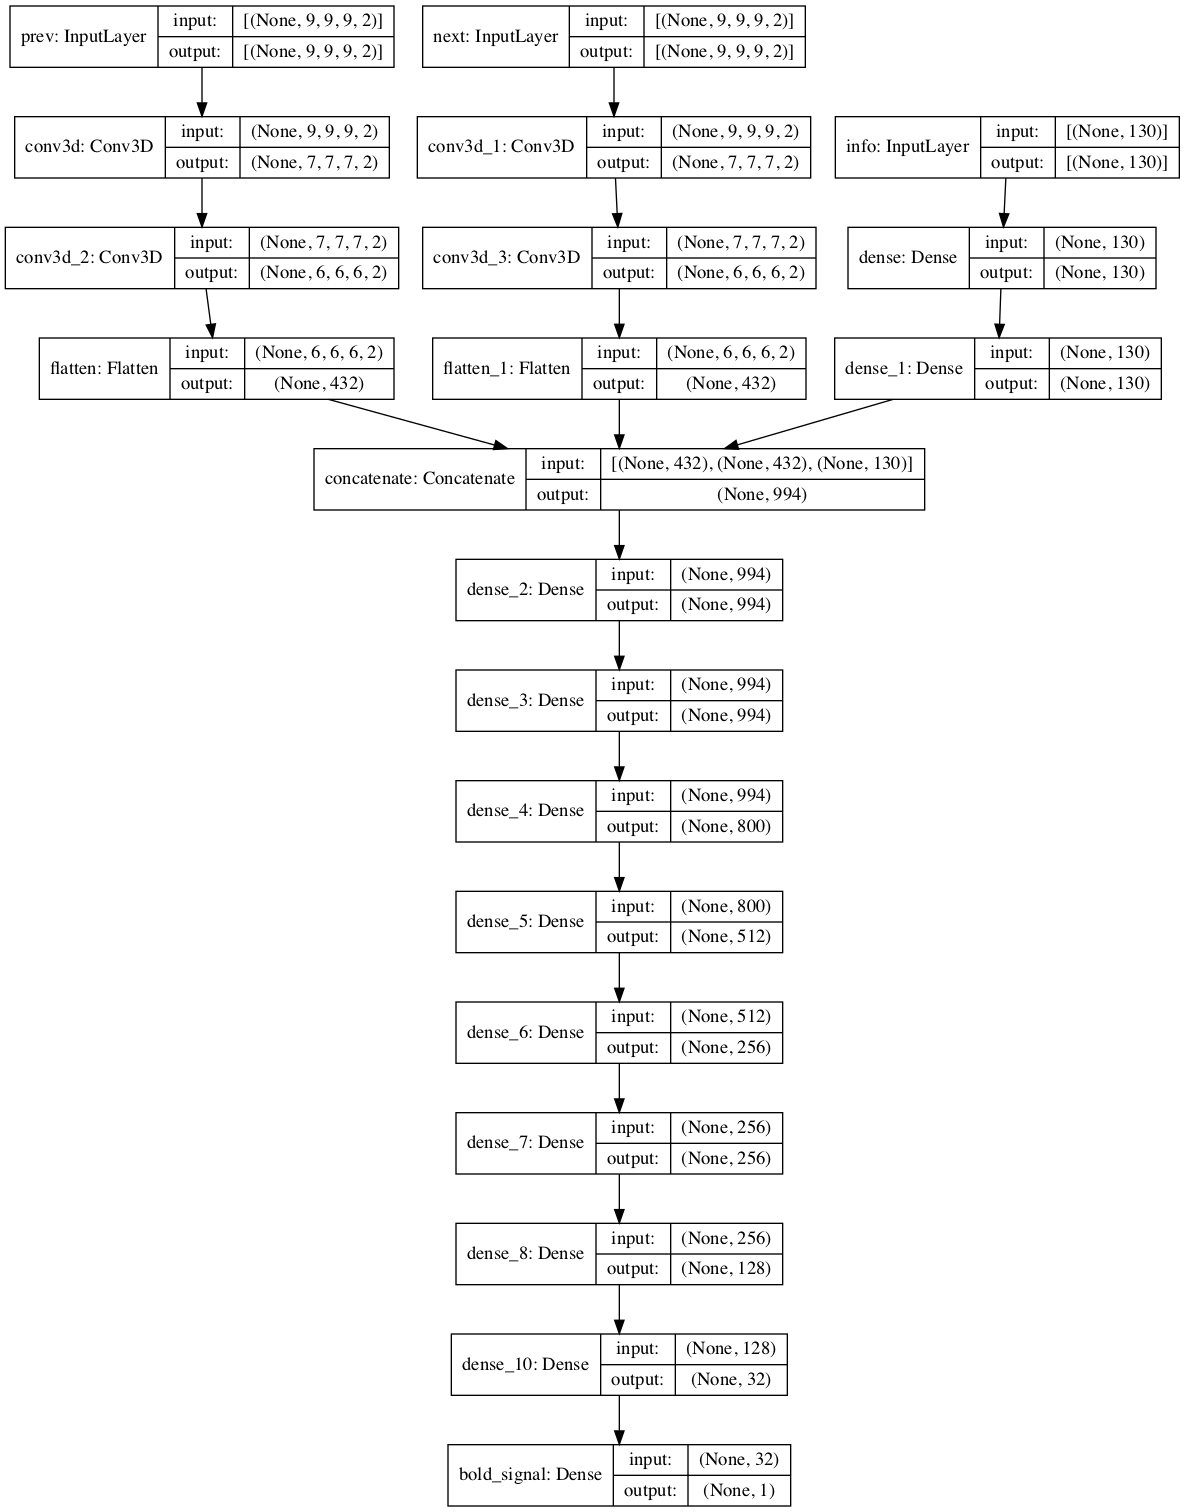

In [6]:
model = _load_model()
keras.utils.plot_model(model, show_shapes=True)

### Setup

In [7]:
df                = pd.read_csv("/Volumes/hd_4tb/project/model_input.csv")
available_volumes = np.load("available_volumes.npy")
train_cols        = [c for c in df.columns if c.startswith("is_")] + ["age"]

history_path = "/Volumes/hd_4tb/results/history.csv"
checkpoint_path = "/Volumes/hd_4tb/results/checkpoints"
batch_size  = 128
num_epoches = 1

### Train

For working with multiple inputs/outputs see [here](https://www.tensorflow.org/guide/keras/functional#models_with_multiple_inputs_and_outputs).  NN advice [here](https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn?noredirect=1&lq=1)

In [ ]:
def cartesian(data, timepoints):
    ret = list()
    for x, y, z in data:
        for t in timepoints:
            ret.append((x, y, z, t))
    return ret

for i, row in df.iterrows():
    print(_get(row, "project"), _get(row, "subject"), _get(row, "time_session"), _get(row, "task"))
    TR = 2 if _get(row, "is_mb") == 0 else 0.71
    task = _get(row, "task")
    save_path = join(checkpoint_path, "weights%04d.h5" % i)
    if os.path.isfile(save_path):
        continue
    fmri_path = _fmri_path(row)
    fmri      = _get_data(join(fmri_path, "normalized.nii.gz"))
    grey      = _get_data(join(fmri_path, "..", "structural", "gm_probseg.nii.gz"))
    onset_df  = pd.read_csv(join(fmri_path, "onsets.csv"))
    info = pd.concat([pd.DataFrame(row[train_cols]).T] * batch_size).reset_index(drop=True)
    
    batch = {"prev": list(), "next": list()}
    bold_signal, mask_rows = list(), list()
    training_voxels = cartesian( available_volumes, np.array(range(1, fmri.shape[3]-1)) )
    training_index = random.sample(range(len(training_voxels)), batch_size*10)

    for j in tqdm(training_index):
        x, y, z, t = training_voxels[j]
        onsets = last_onset(onset_df, task, TR * t, max_time=1000)
        onsets = pd.concat([onsets] * batch_size).reset_index(drop=True)
        
        mask_rows.append( _mask_info(masks, fmri, grey, (x, y, z, t))  )
        grey_data = nii_input(grey, x, y, z)
        for name, timepoint in [("prev", t-1), ("next", t+1)]:
            batch[name].append(
                np.stack((_load_volume(fmri, x, y, z, timepoint), grey_data), axis=3)
            )
        bold_signal.append(fmri[x, y, z, t])
        
        ### Fit to data
        if len(batch["prev"]) == batch_size:
            batch["info"] = pd.concat([
                onsets, info, pd.DataFrame(mask_rows)
            ], axis=1)
            batch["prev"], batch["next"] = np.array(batch["prev"]), np.array(batch["next"])
            history = model.fit(
                batch, {'bold_signal': np.array(bold_signal)},
                epochs=num_epoches, batch_size=16
            )
            if os.path.isfile(history_path):
                pd.concat([pd.read_csv(history_path), pd.DataFrame(history.history)]).to_csv(history_path, index=False)
            else:
                pd.DataFrame(history.history).to_csv(history_path, index=False)
            batch = {"prev": list(), "next": list()}
            bold_signal, mask_rows = list(), list()
    model.save(save_path)

connhc conn001 s1 conscious
